#                              Deep Learning - Final Project

###                                  *Trinidad Bosch*

###      The Simpsons                         
___________


### Step 1: Dataset Analysis and manipulation
- drop null values
- look data and make decisions in terms of filtering

This dataset contains the lines of the 27 first seasons of 'The Simpsons'. It contains 2 columns: character and spoken words.

In [1]:
import pandas as pd #for data handling
import re #for preprocessing
import time #to check time of operations
import matplotlib.pyplot as mp #for visualization

In [2]:
#Import dataset 
df = pd.read_csv (r'simpsons_dataset.csv')
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [3]:
#Renaming columns for better use
df.rename(columns = {'raw_character_text':'character', 'spoken_words':'text'}, inplace = True)
df.head()

,character,text
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [4]:
#Check if there are null in the data set
df.isnull().sum()

character    17814
text         26459
dtype: int64

In [5]:
#Dropping null values before text preprocessing
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

character    0
text         0
dtype: int64

In [7]:
#df.head()

>Before doing any preprocessing we wanted to have a look on the most important characters of the serie, therefore decided to  filter the dataset and work with those characters that have more than 500 dialogue lines. 

In [13]:
#Check the % count of the dialogues of each character
df.character.value_counts(normalize=True)*100
df.character.value_counts()
#len(df['text'])

Homer Simpson               27850
Marge Simpson               13172
Bart Simpson                12995
Lisa Simpson                10756
C. Montgomery Burns          3077
                            ...  
Male Singers                    1
Australian Runner               1
JAZZ MUSICIAN #2/MARBLES        1
Patron #1                       1
LAMAZE INSTRUCTOR               1
Name: character, Length: 6272, dtype: int64

<AxesSubplot:>

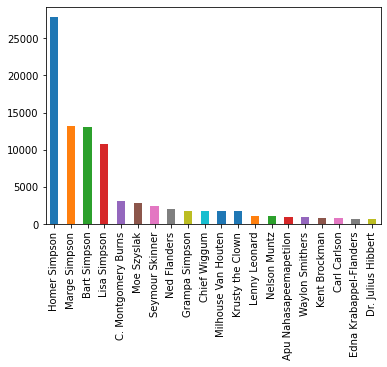

In [7]:
df['character'].value_counts()[:20].plot(kind='bar')

50% of the total lines dialogues corresponds to the Simpson family where Homer 20% of the total. To have a more meaningfull analysis we decided to work with those characters where the count of dialogues is above 1000.

In [6]:
#creating a column that stores the count of each character in the data set 
df['count'] = df.groupby(['character'])['character'].transform('count')

In [15]:
#Filter those characters that have a count of 1000 or more
final_df = df.loc[df['count'] >= 1000] 
#final_df

In [16]:
final_df.character.value_counts()
len_ = len(final_df['text'])
len_1 = len(df['text'])
print('-------')
print(f'We will work with {len_} dialogues which corresponds to a {format(((len_/len_1)*100),".2f")} % of the original dataset') 
print('-------')

-------
We will work with 84427 dialogues which corresponds to a 64.03 % of the original dataset
-------


### Step 2: Extracting contextualized Embeddings
> Add description here

In [58]:
pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85 kB 4.6 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.0 MB 19.1 MB/s            
     |█████████████████████▉          | 600.2 MB 120.2 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 14 kB/s               
     |████████████████████████████████| 23.3 MB 20.1 MB/s            
     |████████████████████████████████| 1.3 MB 57.7 MB/s            
     |████████████████████████████████| 67 kB 8.8 MB/s             
     |████████████████████████████████| 880 kB 56.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 6.6 MB 36.4 MB/s            
     |██████████████████████          | 608.1 MB 116.3 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 25 kB/s               
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e1b8df5573a967f12cb7c0d925a093979c2bedbc6db5d483ffaa92fedc7b3002
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/c9/90/11/0e58d454669bc8daf94e04a8da9956aa6f78eb10cddb16dd4e
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1b90de75bfaa86e7c84b6a609ee24bb901b3e30b8ca0e901a9e74ce365fb37e3
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/4c/64/31/e9900a234b23fb3e9dc565d6114a9d6ff84a72dbdd356502b4
Successfully built sentence-transformers sacremoses
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this direct

In [18]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import BertTokenizer, BertModel
import pickle, pathlib, re, os
import numpy as np
import keras
from keras import models
from keras import layers
from keras.models import Sequential

In [19]:
if torch.cuda.is_available(): #check if GPU is available      
    device = torch.device("cuda:1") #set device, we need this later to push our model and the data to the GPU to perform computations
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
Device name: Quadro RTX 5000


In [20]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  ).to(device) #push the model into the gpu.

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Loading BERT tokenizer...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [21]:
# get embeddings for all words in sentences
def emb_func(sentences):
    
    # Add the special tokens with encode plus.
    encoding = tokenizer.encode_plus(sentences, add_special_tokens = True, truncation=True, padding=True,return_attention_mask= True, return_tensors="pt") 

    tokens_tensor = encoding["input_ids"] 
    segments_tensors = encoding["attention_mask"] 
    segments_ids = encoding["token_type_ids"]
    
    with torch.no_grad():

        outputs = model(tokens_tensor.to(device), segments_tensors.to(device)) #fit the vectors into the moedel

    hidden_states = outputs[2] #extraction of hidden states
    
    
    del outputs   #free gpu --- freeing GPU we avoid CUDA out of memory problem on the server.
    

    token_embeddings = torch.stack(hidden_states, dim=0) # torch.Size([13, 1, 73, 768])
    
    token_embeddings = torch.squeeze(token_embeddings, dim=1) #torch.Size([13, 73, 768])
    
    token_embeddings = token_embeddings.permute(1,0,2) #torch.Size([73, 13, 768])
    
    #Extracting CLS embedding
    cls_emb = token_embeddings[0][-4:].mean(dim=0).detach().cpu().numpy() #Extraction of CLS embeddings

    # Alternatively we store the token vectors
    sent_token_vecs_avg = []

    # For each token in the sentence...
    for token in token_embeddings:
        tok = token.to("cpu")   #feed into a cpu
        token.detach() #deletion of the token in GPU 
        del token  

        # Average last four layers.
        sum_vec = torch.mean(tok[-4:], dim=0)
    
        sent_token_vecs_avg.append(sum_vec)

    b_emb = torch.stack(sent_token_vecs_avg, dim=0).mean(dim=0).detach().cpu().numpy() #Extraction of the summed embeddings
        
    return b_emb, cls_emb 

In [14]:
def embedding_fun(text): 
    
    #adding the special [CLS] and [SEP] tokens
    marked_text = "[CLS] " + text + " [SEP]" 

    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
    #model.eval()
    
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    
    hidden_states = outputs[2]
    
    del outputs #free gpu
    
    # `hidden_states` has shape [13 x 1 x 22 x 768]
    token_embeddings = torch.stack(hidden_states, dim=0)

    # Remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    
    token_embeddings = token_embeddings.permute(1,0,2)
   
    #Extracting CLS embedding
    cls_emb = token_embeddings[0][-4:].mean(dim=0).detach().cpu().numpy()

    
    #GENERATING SENTENCE VECTOR
    # extracting layer 12 of the network
    token_vecs = hidden_states[-1][0]

    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    
    #print ("Sentence embedding vector of shape:", sentence_embedding.size())

    return sentence_embedding, cls_emb

In [8]:
text_list = final_df.text.values.tolist()
labels_list = final_df.character.values.tolist()
print(text_list[:10])
print(labels_list[:10])
type(text_list[0])

NameError: name 'final_df' is not defined

In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [24]:
from tqdm import tqdm

avg_embeddings = []
cls_embeddings = []

for idx in tqdm(range(0, len(text_list)), desc ="Creating sentence embeddings"):

    b_emb, cls_emb = emb_func(text_list[idx])
    avg_embeddings.append(b_emb)
    cls_embeddings.append(cls_emb)

Creating sentence embeddings: 100%|██████████| 84427/84427 [16:21<00:00, 86.01it/s] 


In [25]:
len(avg_embeddings)

84427

In [24]:
#avg_embeddings
#len(avg_embeddings)

In [26]:
# #Saving Embeddings
with open('avg_embeddings.pkl', 'wb') as handle:
    pickle.dump(avg_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('cls_embeddings.pkl', 'wb') as handle:
    pickle.dump(cls_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
#Loading Embeddings
with open('avg_embeddings.pkl', 'rb') as handle:
    avg_embeddings = pickle.load(handle)

with open('cls_embeddings.pkl', 'rb') as handle:
    cls_embeddings = pickle.load(handle)

## Step 3: Multi-class classification

As our aim is to predict the character of a sentence, our task is a Multi-class classification one where we will train a model with labeled data (name of characters.


### Classification with averaged embeddings

In [14]:
type(avg_embeddings)
#avg_embeddings

list

In [22]:
#arrange indices 
indices = np.arange(np.array(avg_embeddings).shape[0])
np.random.shuffle(indices)

NameError: name 'avg_embeddings' is not defined

In [13]:
#avg_embeddings = [t.detach().numpy() for t in avg_embeddings]
avg_embeddings, labels = np.array(avg_embeddings), np.array(labels_list)

In [14]:
avg_embeddings = avg_embeddings[indices]
labels_list = labels[indices]
labels_list = np.unique(labels_list, return_inverse=True)[1]

In [15]:
#Define train and test set
training_samples = (max(indices) * 80)//100 #dividing 80%
validation_samples = int(0.10*(len(avg_embeddings))) 

x_train = avg_embeddings[:training_samples]
y_train = labels_list[:training_samples]

x_test = avg_embeddings[training_samples:]
y_test = labels_list[training_samples:]

In [16]:
x_train.shape

(67540, 768)

In [17]:
# convert to categorical labels
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### 1. Model - One simple layer

- first model with 'adam' optimizer

In [25]:
len(set(labels))

14

In [20]:
# Defining the model
model = Sequential()
#input layer with half nodes as output layer
model.add(layers.Dense(len(set(labels))/2, activation='relu', input_shape=(768,))) 

#output with 14 nodes as 14 characters to analize
model.add(layers.Dense(len(set(labels)), activation='softmax')) 

#tried rmsprop, adagrad but adamax seems better
#also tried categorical_crossentropy for loss but was not working so used sparse_categorical
#https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7)                 5383      
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
Total params: 5,495
Trainable params: 5,495
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train,
                            epochs=12,
                            batch_size=64,
                            validation_split=0.2)
model.save_weights('tbbt.h5')

Epoch 1/12
845/845 [==============================] - 1s 1ms/step - loss: 2.1228 - acc: 0.3329 - val_loss: 2.0034 - val_acc: 0.3508
Epoch 2/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9895 - acc: 0.3502 - val_loss: 1.9689 - val_acc: 0.3565
Epoch 3/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9564 - acc: 0.3564 - val_loss: 1.9432 - val_acc: 0.3645
Epoch 4/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9311 - acc: 0.3663 - val_loss: 1.9220 - val_acc: 0.3751
Epoch 5/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9105 - acc: 0.3745 - val_loss: 1.9066 - val_acc: 0.3767
Epoch 6/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8931 - acc: 0.3787 - val_loss: 1.8965 - val_acc: 0.3816
Epoch 7/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8797 - acc: 0.3839 - val_loss: 1.8826 - val_acc: 0.3836
Epoch 8/12
845/845 [==============================] - 1s 1ms/step - loss: 1.

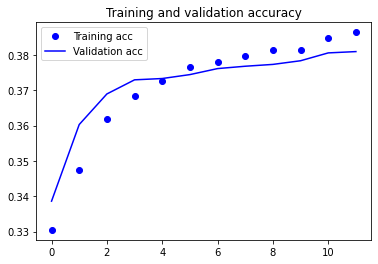

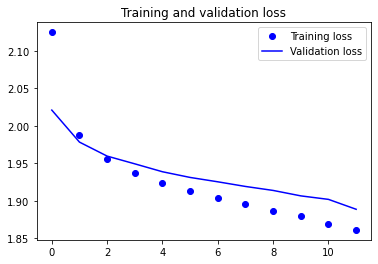

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
model.load_weights("tbbt.h5")
model.evaluate(x_test, y_test)

528/528 [==============================] - 0s 610us/step - loss: 1.8851 - acc: 0.3820


[1.8850756883621216, 0.3820098340511322]

____________
- second model with 'rmsprop' optimizer and one layer 
___________


In [24]:
# Defining the model
model2 = Sequential()
#input layer with half nodes as output layer
model2.add(layers.Dense(len(set(labels))/2, activation='relu', input_shape=(768,))) 

#output with 14 nodes as 14 characters to analize
model2.add(layers.Dense(len(set(labels)), activation='softmax')) 

#tried rmsprop, adagrad but adamax seems better
#also tried categorical_crossentropy for loss but was not working so used sparse_categorical
#https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 7)                 5383      
_________________________________________________________________
dense_7 (Dense)              (None, 14)                112       
Total params: 5,495
Trainable params: 5,495
Non-trainable params: 0
_________________________________________________________________


In [25]:
history2 = model2.fit(x_train, y_train,
                            epochs=12,
                            batch_size=64,
                            validation_split=0.2)
model2.save_weights('tbbt.h5')

Epoch 1/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0271 - acc: 0.3437 - val_loss: 1.9774 - val_acc: 0.3572
Epoch 2/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9674 - acc: 0.3586 - val_loss: 1.9530 - val_acc: 0.3645
Epoch 3/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9355 - acc: 0.3711 - val_loss: 1.9260 - val_acc: 0.3727
Epoch 4/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9056 - acc: 0.3781 - val_loss: 1.9024 - val_acc: 0.3747
Epoch 5/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8835 - acc: 0.3839 - val_loss: 1.9017 - val_acc: 0.3678
Epoch 6/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8674 - acc: 0.3878 - val_loss: 1.8782 - val_acc: 0.3824
Epoch 7/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8547 - acc: 0.3905 - val_loss: 1.8691 - val_acc: 0.3878
Epoch 8/12
845/845 [==============================] - 1s 1ms/step - loss: 1.

In [26]:
model2.load_weights("tbbt.h5")
model2.evaluate(x_test, y_test)

528/528 [==============================] - 0s 617us/step - loss: 1.9040 - acc: 0.3722


[1.9040498733520508, 0.37217977643013]

No much difference when changing the optimizer function so let's play with the numer of layers.

### 2. Model - Adding 2 layers


In [65]:
x_train.shape

(67540, 768)

In [38]:
# Defining the model
model3 = Sequential()
#input layer with half nodes as output layer
model3.add(layers.Dense(len(set(labels))/2, activation='relu', input_shape=(768,))) 
model3.add(layers.Dense(len(set(labels))/2, activation='relu'))
model3.add(layers.Dense(len(set(labels))/2, activation='relu'))

#output with 14 nodes as 14 characters to analize
model3.add(layers.Dense(len(set(labels)), activation='softmax')) 

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 7)                 5383      
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_24 (Dense)             (None, 14)                112       
Total params: 5,607
Trainable params: 5,607
Non-trainable params: 0
_________________________________________________________________


In [39]:
history3 = model3.fit(x_train, y_train,
                            epochs=12,
                            batch_size=64,
                            validation_split=0.2)
model3.save_weights('tbbt.h5')

Epoch 1/12
845/845 [==============================] - 2s 1ms/step - loss: 2.0373 - acc: 0.3340 - val_loss: 1.9805 - val_acc: 0.3465
Epoch 2/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9582 - acc: 0.3555 - val_loss: 1.9502 - val_acc: 0.3624
Epoch 3/12
845/845 [==============================] - 1s 1ms/step - loss: 1.9213 - acc: 0.3669 - val_loss: 1.9133 - val_acc: 0.3729
Epoch 4/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8932 - acc: 0.3783 - val_loss: 1.9147 - val_acc: 0.3650
Epoch 5/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8767 - acc: 0.3824 - val_loss: 1.8929 - val_acc: 0.3763
Epoch 6/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8648 - acc: 0.3872 - val_loss: 1.8888 - val_acc: 0.3807
Epoch 7/12
845/845 [==============================] - 1s 1ms/step - loss: 1.8566 - acc: 0.3887 - val_loss: 1.8821 - val_acc: 0.3769
Epoch 8/12
845/845 [==============================] - 1s 1ms/step - loss: 1.

In [32]:
model3.load_weights("tbbt.h5")
model3.evaluate(x_test, y_test)

528/528 [==============================] - 0s 650us/step - loss: 1.8856 - acc: 0.3796


[1.8855785131454468, 0.3796411454677582]

Okay, so the model doesnt improve with 2 more layers, let's try changing the nodes.

### 2. Model - 2 layes and double amount of nodes

In [36]:
# Defining the model
model4 = Sequential()
model4.add(layers.Dense(len(set(labels))*2, activation='relu', input_shape=(768,)))
model4.add(layers.Dense(len(set(labels))*2, activation='relu'))

model4.add(layers.Dense(len(set(labels)), activation='softmax'))



model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model4.summary()
history = model4.fit(x_train, y_train,
                            epochs=12,
                            batch_size=32,
                            validation_split=0.2)
model4.save_weights('tbbt.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 28)                21532     
_________________________________________________________________
dense_18 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_19 (Dense)             (None, 14)                406       
Total params: 22,750
Trainable params: 22,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
1689/1689 [==============================] - 3s 1ms/step - loss: 1.9478 - acc: 0.3578 - val_loss: 1.8929 - val_acc: 0.3796
Epoch 2/12
1689/1689 [==============================] - 2s 1ms/step - loss: 1.8522 - acc: 0.3858 - val_loss: 1.8492 - val_acc: 0.3908
Epoch 3/12
1689/1689 [==============================] - 2s 1ms/step - loss: 1.8158 - acc: 0.3985 - val_loss: 1.8

In [34]:
model4.load_weights("tbbt.h5")
model4.evaluate(x_test, y_test)

528/528 [==============================] - 0s 629us/step - loss: 1.9004 - acc: 0.3862


[1.9004130363464355, 0.38615503907203674]

### 3. Model with CLS embeddings
As the other models had very low accuracy we will see how the model behaves if we use the CLS embeddings instead of the sentence embedding to check if the results are better.

In [42]:
#arrange indices 
indices = np.arange(np.array(cls_embeddings).shape[0])
np.random.shuffle(indices)

cls_embeddings, labels = np.array(cls_embeddings), np.array(labels_list)

cls_embeddings = cls_embeddings[indices]
labels_list = labels[indices]
labels_list = np.unique(labels_list, return_inverse=True)[1]

In [44]:
#Define train and test set
training_samples_cls = (max(indices) * 80)//100 #dividing 80%
validation_samples = int(0.10*(len(cls_embeddings))) 

x_train_cls = cls_embeddings[:training_samples]
y_train_cls = labels_list[:training_samples]

x_test_cls = cls_embeddings[training_samples:]
y_test_cls = labels_list[training_samples:]

In [45]:
# convert to categorical labels
from tensorflow.keras.utils import to_categorical

y_train_cls = to_categorical(y_train_cls)
y_test_cls = to_categorical(y_test_cls)

In [48]:
# Defining the model
model_cls = Sequential()
#input layer with half nodes as output layer
model_cls.add(layers.Dense(len(set(labels))/2, activation='relu', input_shape=(768,))) 

#output with 14 nodes as 14 characters to analize
model_cls.add(layers.Dense(len(set(labels)), activation='softmax')) 

#tried rmsprop, adagrad but adamax seems better
#also tried categorical_crossentropy for loss but was not working so used sparse_categorical
#https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

model_cls.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['acc'])
model_cls.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 7)                 5383      
_________________________________________________________________
dense_30 (Dense)             (None, 14)                112       
Total params: 5,495
Trainable params: 5,495
Non-trainable params: 0
_________________________________________________________________


In [49]:
history_cls = model_cls.fit(x_train_cls, y_train_cls,
                            epochs=12,
                            batch_size=64,
                            validation_split=0.2)
model_cls.save_weights('tbbt.h5')

Epoch 1/12
845/845 [==============================] - 2s 2ms/step - loss: 2.1984 - acc: 0.2881 - val_loss: 2.0857 - val_acc: 0.3250
Epoch 2/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0762 - acc: 0.3297 - val_loss: 2.0788 - val_acc: 0.3251
Epoch 3/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0743 - acc: 0.3297 - val_loss: 2.0793 - val_acc: 0.3250
Epoch 4/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0734 - acc: 0.3297 - val_loss: 2.0798 - val_acc: 0.3251
Epoch 5/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0727 - acc: 0.3297 - val_loss: 2.0795 - val_acc: 0.3250
Epoch 6/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0722 - acc: 0.3297 - val_loss: 2.0791 - val_acc: 0.3250
Epoch 7/12
845/845 [==============================] - 1s 1ms/step - loss: 2.0718 - acc: 0.3297 - val_loss: 2.0791 - val_acc: 0.3251
Epoch 8/12
845/845 [==============================] - 1s 1ms/step - loss: 2.

In [50]:
model_cls.load_weights("tbbt.h5")
model_cls.evaluate(x_test_cls, y_test_cls)

528/528 [==============================] - 0s 607us/step - loss: 2.0620 - acc: 0.3342


[2.0620415210723877, 0.3341623842716217]

___________
# Try to fine-tune a pretrained bert?

__________


************

## Second part: Clustering sentences

Well as we can see the networks models we built have very low accuracy, so we will try to build clusters (non supervised task) to check if we are able to differentiate the sentences per character.

To simplify this task we will work only with The Simpsons family members (Homer, Marge, Bart and Lisa).


### Step 1: clustering with kmeans

In [22]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

In [23]:
final_df.character.value_counts()

NameError: name 'final_df' is not defined

In [24]:
#Filter Simpsons family
final_df2 = df.loc[df['count'] >= 10756] 
#final_df

In [25]:
final_df2.character.value_counts()
len_ = len(final_df2['text'])
len_1 = len(df['text'])
print('-------')
print(f'We will work with {len_} dialogues which corresponds to a {format(((len_/len_1)*100),".2f")} % of the original dataset') 
print('-------')

-------
We will work with 64773 dialogues which corresponds to a 49.13 % of the original dataset
-------


In [26]:
sentences2 = final_df2['text'].tolist()
len(sentences2)

64773

In [15]:
#torch.cuda.empty_cache()

In [27]:
#embeddings for second part

from tqdm import tqdm

fam_embeddings = []
fam_cls_embeddings = []

for idx in tqdm(range(0, len(sentences2)), desc ="Creating sentence embeddings"):

    b_emb, cls_emb = emb_func(sentences2[idx])
    fam_embeddings.append(b_emb)
    fam_cls_embeddings.append(cls_emb)

Creating sentence embeddings: 100%|██████████| 64773/64773 [10:59<00:00, 98.26it/s] 


In [28]:
# #Saving Embeddings
with open('fam_embeddings.pkl', 'wb') as handle:
    pickle.dump(fam_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Loading Embeddings
with open('fam_embeddings.pkl', 'rb') as handle:
    fam_embeddings = pickle.load(handle)

In [39]:
##kmeans uses euclidean distance by default so in this step we normalize to unit vectors
bert_norm = preprocessing.normalize(fam_embeddings, norm='l2') 
#bert_norm

bert_list = bert_norm.tolist() #for input to kmeans
type(bert_list)

list

In [77]:
#Clustering process
k=4 #as 4 family members

#initializing model
kmeans_bert = KMeans(n_clusters = k, algorithm = 'auto')

#fitting the model
fit_bert = kmeans_bert.fit(bert_list)

#predicting step
predict_bert = kmeans_bert.predict(bert_list)

In [79]:
final_df2['ClusterID_BERT'] = kmeans_bert.labels_

final_df2.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,character,text,count,ClusterID_BERT
1,Lisa Simpson,Where's Mr. Bergstrom?,10756,1
3,Lisa Simpson,That life is worth living.,10756,3
7,Bart Simpson,Victory party under the slide!,12995,0
8,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!,10756,0
10,Lisa Simpson,Do you know where I could find him?,10756,1


In [84]:
cluster_0 = final_df2[final_df2['ClusterID_BERT'] == 0] 
cluster_1 = final_df2[final_df2['ClusterID_BERT'] == 1] 
cluster_2 = final_df2[final_df2['ClusterID_BERT'] == 2]
cluster_3 = final_df2[final_df2['ClusterID_BERT'] == 3]

In [81]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

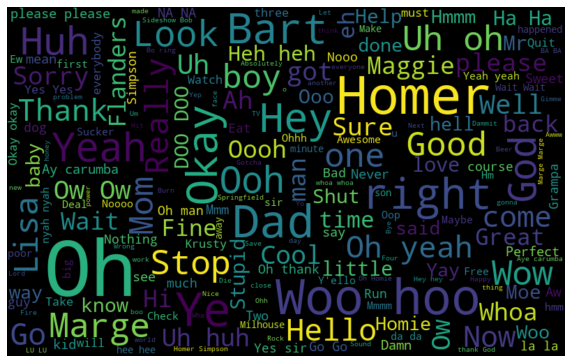

In [82]:
#Cluster 0
all_words = ' '.join([text for text in cluster_0['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

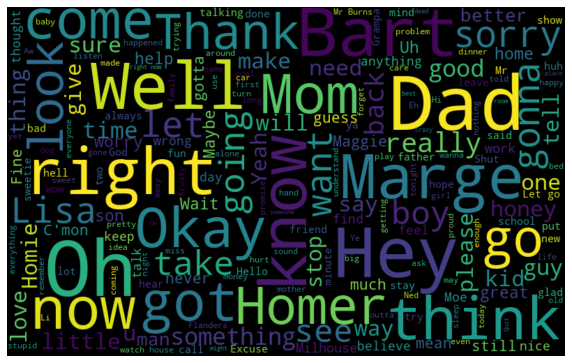

In [83]:
#Cluster 1
all_words = ' '.join([text for text in cluster_1['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

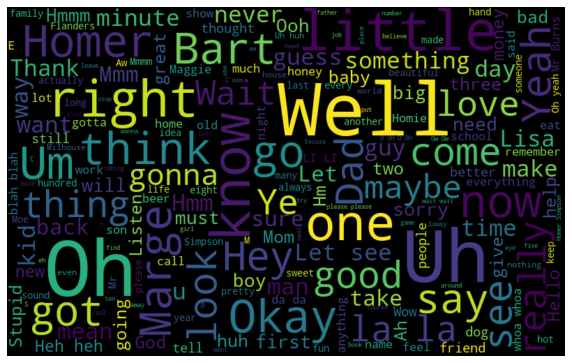

In [85]:
#Cluster 2
all_words = ' '.join([text for text in cluster_2['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

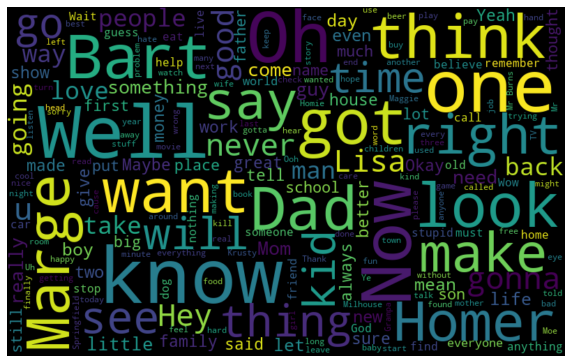

In [86]:
#Cluster 3
all_words = ' '.join([text for text in cluster_3['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

All three clusters look quite similar, so the sentence model doesnt really differentiate by character. We can see that most of the characters talk about simmilar things on they dialogues.

### Step 2: clustering with hdbscan

As the last clustering method did not work very well we will try to see if another method is more capable to detect differences between characters depending on their dialogues. 

For this task we will do Topic Analysis with a pretrained bert model and extract clusters using hdbscan as method.

In [87]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 88 kB 6.6 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.4 MB 21.0 MB/s            
     |████████████████████████████████| 1.1 MB 50.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 25.3 MB 100.6 MB/s            
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=5bdbced7233886274e1e3f47a4bcba607a79817d0733d32194437ca58cb01591
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/54/ca/cf/35a4f9a744b0bce9549e4e492261bef3903434d0118f3ee858
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=23c31af86ad1dbd713cffb002456e7b954054ead219773fc95720047734b7116
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/fd/8a/9e/58bdbe4211581dd2aeffe2

In [88]:
pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.2 MB 8.8 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 6.4 MB 43.3 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 306 kB 75.4 MB/s            
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp36-cp36m-linux_x86_64.whl size=2318813 sha256=e7081a93e4d7b7c1459d9611444844a2870e573004851bdb9ba24a5841546089
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/70/52/fe/83ef5a0e879c48df9968d931d41046226e4cb19a166f0223d2
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [89]:
pip install bertopic

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 57 kB 4.9 MB/s             
     |████████████████████████████████| 57 kB 7.6 MB/s             
     |████████████████████████████████| 55 kB 8.3 MB/s             
     |████████████████████████████████| 55 kB 5.4 MB/s             
     |████████████████████████████████| 53 kB 5.0 MB/s              
     |████████████████████████████████| 53 kB 3.0 MB/s             
     |████████████████████████████████| 40 kB 6.8 MB/s             
     |████████████████████████████████| 9.5 MB 45.2 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [29]:
import umap
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan

In [65]:
# Define UMAP model to reduce embeddings dimension
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory=False)

# Define HDBSCAN model to perform documents clustering
#min_cluster_size tried different parameters, with n=50 was retrieving more than 200 clusters
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=200, 
                                min_samples=1,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

In [66]:
#for stopword removal, first iteration without removing them retrieved topics with no much meaning
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english") 

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english',
    calculate_probabilities=True,
    verbose=True,
    umap_model= umap_model,
    hdbscan_model=hdbscan_model,
    )

In [67]:
fam_embeddings = np.array(fam_embeddings) ## transform to array for input
topics, probabilities = model.fit_transform(sentences2, fam_embeddings)

2022-08-14 21:24:53,252 - BERTopic - Reduced dimensionality with UMAP
2022-08-14 21:25:12,890 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [52]:
fam_embeddings = np.array(fam_embeddings) ## transform to no array for input

In [68]:
model.get_topic_freq()

,Topic,Count
0,3,60361
1,-1,3329
2,2,546
3,1,280
4,0,257


In [71]:
# topic '-1' is considered the outlier cluster and can be taken away of the analysis
model.get_topic(2)

[('yes', 0.22263057451117568),
 ('did', 0.14959061191788897),
 ('sure', 0.14588880477293412),
 ('oh', 0.12194083029877818),
 ('guess', 0.10950570742969162),
 ('course', 0.10738281527133686),
 ('dont', 0.09792007226276264),
 ('know', 0.0967268936792558),
 ('didnt', 0.0878241971823426),
 ('im', 0.07744951098510704),
 ('oh dont', 0.074955072693385),
 ('knew', 0.06448386916049124),
 ('yeah', 0.05966597260160835),
 ('does', 0.05629563318079898),
 ('know know', 0.0487138049317389),
 ('im yes', 0.04780139412205963),
 ('yes sure', 0.04621835983315225),
 ('dont yes', 0.040387649172240477),
 ('sure yes', 0.03891012247821093),
 ('yes yes', 0.03889455334710658),
 ('oh yes', 0.038593188201374515),
 ('yeah guess', 0.03723048242805284),
 ('sure did', 0.03696313147056497),
 ('did im', 0.035836645490931),
 ('did did', 0.035459794711288385),
 ('know oh', 0.03495191433808071),
 ('promise', 0.03490965944377262),
 ('guess yes', 0.033425188887489854),
 ('course dont', 0.032820974946167716),
 ('dont did', 0.

Well as far as we can see here and with the kmeans cluster method, there are no really meaningfull groups from the dialogues. Maybe because the dialogues itself are not very meaningful??